In [1]:
import torch
import pickle
import numpy as np
import os
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Assuming the following classes are already defined in your current environment

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]  # Remove last FC and avgpool
        self.resnet = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # to get 2048-dim
        self.linear = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, inputs):
        """
        inputs: (B, C, H, W) for image or (B, T, C, H, W) for video
        """
        if inputs.dim() == 4:  # Single image
            with torch.no_grad():
                features = self.resnet(inputs)  # (B, 2048, H', W')
                features = self.pool(features).squeeze(-1).squeeze(-1)  # (B, 2048)
            features = self.linear(features)  # (B, embed_size)
            features = self.bn(features)
            return features
        
        elif inputs.dim() == 5:  # Video: (B, T, C, H, W)
            B, T, C, H, W = inputs.size()
            inputs = inputs.view(B * T, C, H, W)
            with torch.no_grad():
                features = self.resnet(inputs)  # (B*T, 2048, H', W')
                features = self.pool(features).squeeze(-1).squeeze(-1)  # (B*T, 2048)
            features = self.linear(features)  # (B*T, embed_size)
            features = self.bn(features)
            features = features.view(B, T, -1)  # (B, T, embed_size)
            features = features.mean(dim=1)  # aggregate frame features (B, embed_size)
            return features

        else:
            raise ValueError("Unsupported input shape for EncoderCNN")


# Cell 8: Decoder
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions[:, :-1])
        h0 = self.init_h(features).unsqueeze(0)  # [1, batch, hidden]
        c0 = self.init_c(features).unsqueeze(0)
        hiddens, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(hiddens)
        return outputs
# flicker/Images/3637013_c675de7705.jpg

C:\Users\Nikhil\AppData\Local\Temp\ipykernel_16588\515428039.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/checkpoint_epoch_29.pt

Generated Caption: a group of kids are standing in front of a large tree . <end>


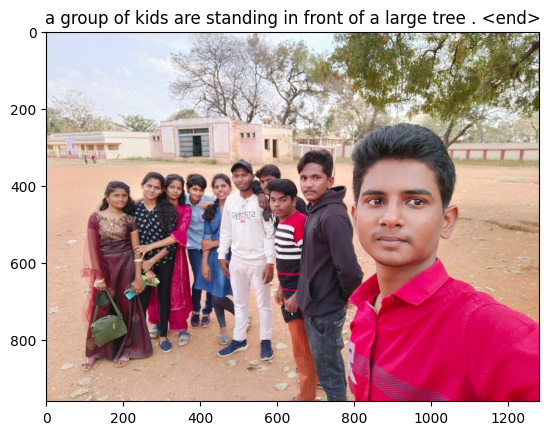

In [2]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import torchvision.models as models
import numpy

# Load the vocab and inv_vocab
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

inv_vocab = {idx: word for word, idx in vocab.items()}

# Load the best model checkpoint (or your desired checkpoint)
checkpoint = torch.load('checkpoints/checkpoint_epoch_29.pt')
encoder = EncoderCNN(embed_size=256).to(device)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab)).to(device)

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
encoder.eval()
decoder.eval()

# Image Preprocessing (should match the same transform used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # These are ImageNet statistics
])

# Load and preprocess the image you want to test on
image_path = 'C:/Users/Nikhil/OneDrive/Pictures/Dell Mobile Connect/IMG-20220115-WA0011.jpg'  # Change this to the path of your image
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Get the features from the encoder
with torch.no_grad():
    features = encoder(image)

# Initialize caption with the <start> token
caption = [vocab['<start>']]  # Start the caption with the <start> token

# Generate the caption using the decoder
max_length = 20  # You can set the maximum length of the caption
for _ in range(max_length):
    # Convert caption to tensor and add batch dimension (shape: [1, sequence_length])
    caption_input = torch.tensor(caption).unsqueeze(0).to(device)
    
    # Ensure that caption_input has a sequence length > 0 before passing it to the LSTM
    if caption_input.size(1) > 0:
        # The LSTM expects the input to have shape [batch_size, seq_len, input_size]
        embeddings = decoder.embedding(caption_input)  # Apply the embedding layer
        h0 = decoder.init_h(features).unsqueeze(0)  # [1, batch, hidden]
        c0 = decoder.init_c(features).unsqueeze(0)

        # Feed the embeddings into the LSTM
        hiddens, _ = decoder.lstm(embeddings, (h0, c0))  # Output from LSTM
        outputs = decoder.linear(hiddens)  # Linear layer to get word predictions
        
        # Get the most likely next word
        predicted_word_idx = outputs.argmax(2)[:, -1].item()
        
        caption.append(predicted_word_idx)  # Append predicted word to the caption list
        
        # Stop when the <end> token is generated
        if predicted_word_idx == vocab['<end>']:
            break

# Convert the generated token IDs back to words
generated_caption = ' '.join([inv_vocab[idx] for idx in caption[1:]])  # Skip <start> token

# Print the final generated caption
print(f"Generated Caption: {generated_caption}")

# Optional: Display the image along with the generated caption (optional, but will still work in background)
image = Image.open(image_path)
plt.imshow(image)
plt.title(generated_caption)
plt.show()


In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.io as io
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import os

# =========================
# Load vocab and model
# =========================
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

inv_vocab = {idx: word for word, idx in vocab.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
checkpoint = torch.load('checkpoints/best_model.pt')
encoder = EncoderCNN(embed_size=256).to(device)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab)).to(device)

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
encoder.eval()
decoder.eval()

# =========================
# Video Frame Sampling
# =========================
def sample_video_frames(video_path, num_frames=10):
    # Load video using torchvision
    video, _, info = io.read_video(video_path, pts_unit='sec')
    total_frames = video.shape[0]
    
    if total_frames < num_frames:
        raise ValueError("Video is too short to sample that many frames.")
    
    indices = torch.linspace(0, total_frames - 1, steps=num_frames).long()
    sampled_frames = video[indices]  # shape: (T, H, W, C)
    sampled_frames = sampled_frames.permute(0, 3, 1, 2)  # (T, C, H, W)
    return sampled_frames

# =========================
# Preprocessing
# =========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def preprocess_video_frames(frames):
    frames = frames.float() / 255.0  # normalize to [0, 1]
    return torch.stack([transform(frame) for frame in frames])  # (T, C, H, W)

# =========================
# Generate Caption
# =========================
def generate_video_caption(frames):
    frames = frames.unsqueeze(0).to(device)  # (1, T, C, H, W)
    with torch.no_grad():
        features = encoder(frames)
        h0 = decoder.init_h(features).unsqueeze(0)
        c0 = decoder.init_c(features).unsqueeze(0)

    caption = [vocab['<start>']]

    for _ in range(20):
        input_tensor = torch.tensor(caption).unsqueeze(0).to(device)
        embeddings = decoder.embedding(input_tensor)
        hiddens, _ = decoder.lstm(embeddings, (h0, c0))
        outputs = decoder.linear(hiddens)
        predicted = outputs.argmax(2)[:, -1].item()
        caption.append(predicted)
        if predicted == vocab['<end>']:
            break

    return ' '.join([inv_vocab[idx] for idx in caption[1:] if idx in inv_vocab])

# =========================
# Test Example
# =========================
video_path = 'path_to_the_video.mp4'  # Change this to your video path
sampled_frames = sample_video_frames(video_path, num_frames=10)
sampled_frames = preprocess_video_frames(sampled_frames)

caption = generate_video_caption(sampled_frames)
print(f"🎬 Video Caption: {caption}")


C:\Users\Nikhil\AppData\Local\Temp\ipykernel_16588\459148759.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt')


🎬 Video Caption: a car driving down a road <end>


In [4]:
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import numpy as np

# ========== Load Vocab ==========
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

inv_vocab = {idx: word for word, idx in vocab.items()}

# ========== Load Models ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderCNN(embed_size=256).to(device)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab)).to(device)

checkpoint = torch.load('checkpoints/best_model.pt', map_location=device)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
encoder.eval()
decoder.eval()

# ========== Video Sampling with OpenCV ==========
def sample_video_frames(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        raise ValueError("Video has fewer frames than requested.")
    
    frame_indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    frames = []
    
    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_indices:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_tensor = transforms.ToTensor()(Image.fromarray(frame))
            frames.append(frame_tensor)
    cap.release()
    
    return torch.stack(frames)  # Shape: (T, C, H, W)

# ========== Preprocessing ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def preprocess_video_frames(frames_tensor):
    transformed_frames = []
    for frame in frames_tensor:
        transformed_frames.append(transform(frame))
    return torch.stack(transformed_frames)  # (T, C, H, W)

# ========== Generate Caption ==========
def generate_video_caption(frames_tensor):
    frames_tensor = frames_tensor.unsqueeze(0).to(device)  # (1, T, C, H, W)
    with torch.no_grad():
        features = encoder(frames_tensor)  # (B=1, embed_size)

    caption = [vocab['<start>']]
    for _ in range(20):
        input_tensor = torch.tensor(caption).unsqueeze(0).to(device)  # (1, seq_len)
        embeddings = decoder.embedding(input_tensor)
        h0 = decoder.init_h(features).unsqueeze(0)
        c0 = decoder.init_c(features).unsqueeze(0)
        hiddens, _ = decoder.lstm(embeddings, (h0, c0))
        outputs = decoder.linear(hiddens)
        predicted_idx = outputs.argmax(2)[:, -1].item()
        caption.append(predicted_idx)
        if predicted_idx == vocab['<end>']:
            break

    return ' '.join([inv_vocab[idx] for idx in caption[1:-1]])  # Exclude <start> and <end>

# ========== Run Example ==========
video_path = "path_to_the_video.mp4"  # 🔁 Replace with your video file path
sampled_frames = sample_video_frames(video_path, num_frames=100)
sampled_frames = preprocess_video_frames(sampled_frames)
caption = generate_video_caption(sampled_frames)

print(f"🎥 Generated Caption: {caption}")


C:\Users\Nikhil\AppData\Local\Temp\ipykernel_16588\4026445230.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pt', map_l

🎥 Generated Caption: a car driving down a road
